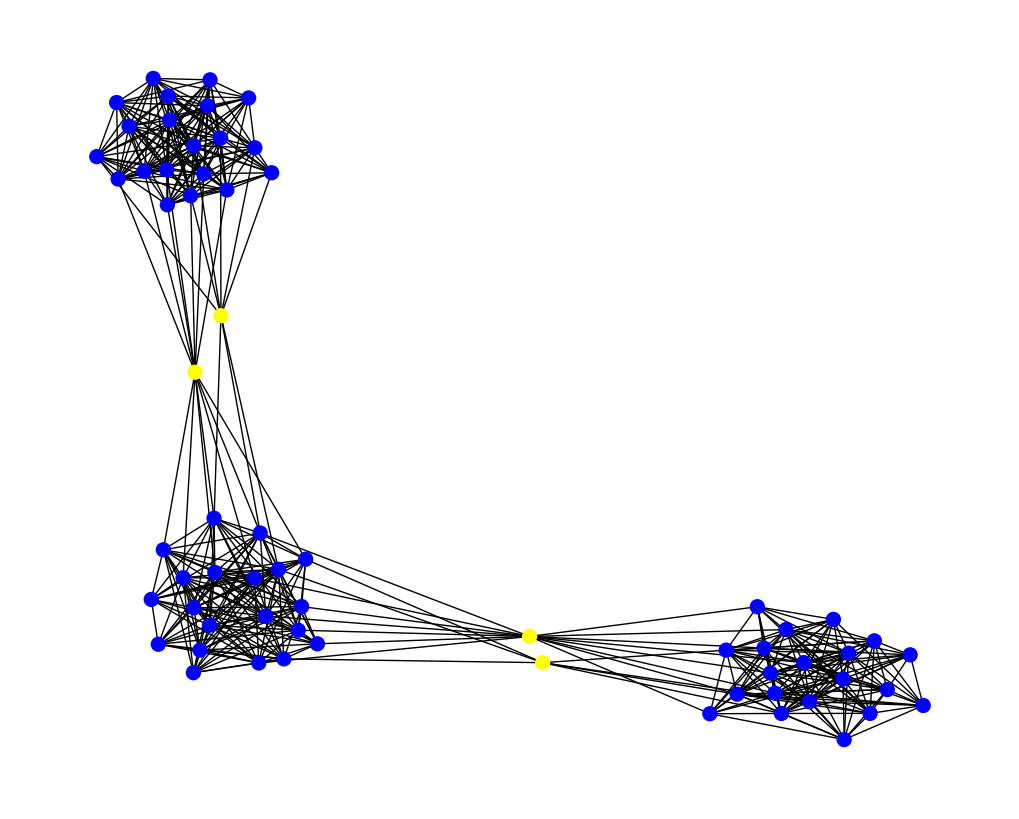

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain

# Parameters
r = 3  # Number of clusters
n = 20  # Number of nodes in each cluster
m = 2  # Number of separators between clusters
p_intra = 0.7  # Probability of edge within clusters
p_inter = 0.3  # Probability of edge between clusters and separators


def generate_seperator_graph(
    num_clusters: int,
    cluster_size: int,
    num_separators: int,
    p_intra: float,
    p_inter: float,
) -> list[tuple[int, int]]:

    # Initialize an empty graph
    G = nx.Graph()

    # Create clusters and add them to the graph
    cluster_edges: list[list[tuple[int, int]]] = []
    clusters = []
    for i in range(num_clusters):
        # Create a random graph for each cluster
        cluster = nx.erdos_renyi_graph(cluster_size, p_intra)

        # Relabel nodes to avoid overlap
        mapping = {node: node + i * cluster_size for node in cluster.nodes()}
        cluster = nx.relabel_nodes(cluster, mapping)

        # Add the cluster to the main graph
        G = nx.compose(G, cluster)

        # Store the nodes in each cluster
        clusters.append(list(cluster.nodes()))
        cluster_edges.append(list(cluster.edges()))

    # Add multiple vertex separators between each cluster
    separators = []
    for i in range(num_clusters - 1):
        sep_nodes = []
        for j in range(num_separators):
            separator = max(G.nodes()) + 1
            sep_nodes.append(separator)
            G.add_node(separator)

            # Connect the separator to nodes in the two clusters it separates
            for node in clusters[i]:
                if np.random.rand() < p_inter:
                    G.add_edge(separator, node)
                    cluster_edges[i].append((separator, node))

            for node in clusters[i + 1]:
                if np.random.rand() < p_inter:
                    G.add_edge(separator, node)
                    cluster_edges[i + 1].append((separator, node))

        separators.append(sep_nodes)

    return chain.from_iterable(cluster_edges)


# Draw the graph
pos = nx.spring_layout(G)  # Layout for better visualization
colors = ["yellow" if node in sum(separators, []) else "blue" for node in G.nodes()]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_color=colors, with_labels=False, node_size=100)
plt.show()

In [ ]:
import random


# Parameters
r = 3  # Number of clusters
n = 20  # Number of nodes in each cluster
m = 5  # Number of connections between clusters
p_intra = 0.7  # Probability of edge within clusters


def generate_clustered_graph(
    r: int, n: int, m: int, p_intra: int
) -> list[tuple[int, int]]:

    # Initialize an empty graph
    G = nx.Graph()

    cluster_edges = []
    # Create clusters and add them to the graph
    clusters = []
    for i in range(r):
        # Create a random graph for each cluster
        cluster = nx.erdos_renyi_graph(n, p_intra)

        # Relabel nodes to avoid overlap
        mapping = {node: node + i * n for node in cluster.nodes()}
        cluster = nx.relabel_nodes(cluster, mapping)

        # Add the cluster to the main graph
        G = nx.compose(G, cluster)

        # Store the nodes in each cluster
        clusters.append(list(cluster.nodes()))
        cluster_edges.append(list(cluster.edges()))

    # Add exactly m connections between each cluster
    for i in range(r - 1):
        connections = 0
        while connections < m:
            # Randomly choose a node from each of the two clusters
            node_from_cluster_1 = random.choice(clusters[i])
            node_from_cluster_2 = random.choice(clusters[i + 1])

            # If there's no edge between these nodes, add one
            if not G.has_edge(node_from_cluster_1, node_from_cluster_2):
                G.add_edge(node_from_cluster_1, node_from_cluster_2)
                cluster_edges[i].append((node_from_cluster_1, node_from_cluster_2))
                connections += 1

    return chain.from_iterable(cluster_edges)

# Draw the graph
pos = nx.spring_layout(G)  # Layout for better visualization
colors = ["blue" for node in G.nodes()]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_color=colors, with_labels=False, node_size=100)
plt.show()

In [1]:
import numpy as np

# Given sorted array a
a = np.array([1, 2, 3, 4, 5])

# Compute probabilities
probabilities = np.abs(a) / np.sum(np.abs(a))

# Number of samples
n = 1000

# Sample indices from the array according to the probabilities
sampled_indices = np.random.choice(len(a), size=n, p=probabilities)

# Count the number of samples for each entry
sample_counts = np.bincount(sampled_indices, minlength=len(a))

# Results
print("Sampled Indices:", sampled_indices)
print("Sample Counts for each entry:", sample_counts)

Sampled Indices: [0 1 1 4 3 4 2 3 1 4 4 2 4 3 4 3 1 4 3 1 4 2 3 0 2 4 4 3 4 3 3 3 3 4 2 4 0
 1 4 2 3 0 4 0 2 1 4 2 4 2 2 0 2 4 3 1 2 4 2 2 1 3 3 0 3 3 4 2 4 4 3 4 4 0
 1 4 3 4 3 3 4 2 3 3 4 4 4 3 1 4 4 4 4 3 1 3 3 4 4 3 4 4 4 3 1 3 4 4 1 3 2
 4 2 4 2 4 3 0 4 4 4 3 3 1 4 2 2 4 1 1 2 2 1 4 4 3 3 4 4 2 4 4 1 4 0 4 4 3
 3 0 0 3 2 4 4 3 1 3 3 3 4 2 0 3 1 0 2 1 4 4 1 3 4 3 3 2 3 2 3 3 4 0 4 4 4
 2 0 3 3 4 3 2 4 3 1 3 4 3 4 4 2 0 2 2 1 4 2 1 1 0 3 0 1 4 1 1 4 4 4 1 2 4
 1 4 1 0 2 4 2 2 1 4 3 2 3 1 2 3 3 3 0 1 3 2 1 3 1 3 0 0 2 2 3 4 2 4 4 1 4
 2 4 3 2 0 2 3 3 4 2 2 4 4 3 4 3 2 2 4 4 3 4 3 4 4 4 2 3 1 4 4 1 2 3 3 0 4
 1 4 3 4 4 3 4 4 4 4 3 4 4 4 2 4 4 3 3 2 2 2 0 0 4 0 1 4 3 4 2 4 3 3 2 3 4
 4 4 1 3 4 2 0 4 0 2 3 3 1 4 0 2 3 4 2 3 0 2 4 4 2 2 4 2 0 2 1 3 3 3 2 4 1
 1 1 4 1 1 3 2 1 3 4 4 4 3 3 0 4 4 3 2 0 2 0 4 3 4 3 2 0 0 3 3 0 2 3 4 2 3
 1 0 2 2 2 2 3 2 0 4 3 2 4 3 3 2 0 0 0 2 4 2 2 3 4 2 4 4 4 3 1 3 4 2 4 2 3
 3 2 4 2 1 4 2 1 3 0 4 3 2 4 3 4 4 4 1 1 0 3 4 4 4 3 1 4 1 4 2 4 3 3 2 4 2
 4 2 2 2